## **Quiz ML No. 3**

---

### MultinomialNB

Nama  : William Yulio

NIM   : 2301869840

Kelas : LD01

### Menghubungkan phyton dengan Drive agar bisa mengakses dataset spam dan ham

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Melakukan instalasi untuk dapat menggunakan library nltk

In [2]:
#!pip install nltk

### Import Library yang akan digunakan

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer
import glob
import os
import numpy as np
from google.colab import drive
import nltk
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Memasukkan dataset yang sudah kita masukkan kedalam drive

In [4]:
file_path = '/content/drive/MyDrive/myham/0001.1999-12-10.farmer.ham.txt'
with open(file_path, 'r') as infile:
    ham_sample = infile.read()
print(ham_sample)

file_path = '/content/drive/MyDrive/myspam/0006.2003-12-18.GP.spam.txt'
with open(file_path, 'r') as infile:
    spam_sample = infile.read()
print(spam_sample)

# Mengakses data kedalam drive untuk mencari dataset sesuai dengan yang sudah kita tuju pada url ini
# ini kita lakukan untuk mengecek apakah file sudah bisa diakses atau tidak

Subject: christmas tree farm pictures

Subject: dobmeos with hgh my energy level has gone up ! stukm
introducing
doctor - formulated
hgh
human growth hormone - also called hgh
is referred to in medical science as the master hormone . it is very plentiful
when we are young , but near the age of twenty - one our bodies begin to produce
less of it . by the time we are forty nearly everyone is deficient in hgh ,
and at eighty our production has normally diminished at least 90 - 95 % .
advantages of hgh :
- increased muscle strength
- loss in body fat
- increased bone density
- lower blood pressure
- quickens wound healing
- reduces cellulite
- improved vision
- wrinkle disappearance
- increased skin thickness texture
- increased energy levels
- improved sleep and emotional stability
- improved memory and mental alertness
- increased sexual potency
- resistance to common illness
- strengthened heart muscle
- controlled cholesterol
- controlled mood swings
- new hair growth and color restore

### Menghilangkan Stop Words

In [5]:
cv = CountVectorizer(stop_words = "english", max_features=500)

# Fungsi CountVectorizer() untuk dapat menghilangkan kata semacam i, you, the, a, this, is, dll 

### Menyimpan email, text data, dan labels

In [6]:
emails, labels = [], []
file_path = '/content/drive/MyDrive/myspam'
for filename in glob.glob(os.path.join(file_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(1)

file_path = '/content/drive/MyDrive/myham'
for filename in glob.glob(os.path.join(file_path, '*.txt')):
    with open(filename, 'r', encoding = "ISO-8859-1") as infile:
        emails.append(infile.read())
        labels.append(0)
# Memasukkan data sesuai dengan email dan label, sehingga dataset sudah kita pisahkan diawal dan disimpan kedalam variabel penampung
# Import glob dan os digunakan untuk mencari semua file .txt  

### Melakukan text cleaning (Lemmatisasi)

In [7]:
def letters_only(astr):
    return astr.isalpha()

all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

def clean_text(docs):
    cleaned_docs = []
    for doc in docs:
        cleaned_docs.append(' '.join([lemmatizer.lemmatize(word.lower()) for word in doc.split() if letters_only(word) and word not in all_names]))
    return cleaned_docs

# Melakukan proses lemmatisasi untuk mendapatkan bentuk kata yang paling dasar berdasarkan dari kata - kata yang ada didalam dataset
# Dan juga menghilangkan punctual dan number value

### Membuat variabel global yang akan digunakan kedalam kalkulasi

In [8]:
cleaned_emails = clean_text(emails)
term_docs = cv.fit_transform(cleaned_emails)
feature_mapping = cv.vocabulary
feature_names = cv.get_feature_names()

# cleaned emails berisi email yang sudah di lematisasi
# term_docs digunakan untuk menampung dokumen matrix(yang berisi sekumpulan data) kedalam bentuk dokumen matrix yang menunjukkan frequency sparse vector dari dokumen dan email tersebut
 

### Kalkulasi untuk membuat perhitungan untuk membangun spam filtering model

In [9]:
def get_label_index(labels):
    from collections import defaultdict
    label_index = defaultdict(list)
    for index, label in enumerate(labels):
        label_index[label].append(index)
    return label_index

# Disini kita akan mendapatkan grup label dengan menggunakan label_index

def get_prior(label_index):
    prior = {label: len(index) for label, index in label_index.items()}
    total_count = sum(prior.values())
    for label in prior:
        prior[label] /= float(total_count)
    return prior

# Setelah mendapatkan label_index, kita akan melakukan kalkulasi untuk mendapatkan prior
# yaitu probabilitas distribusi untuk melihat probabilitas dari obejct yang belum pernah kita obeservasi

In [10]:
def get_likelihood(term_document_matrix, label_index, smoothing=0):
    likelihood = {}
    for label, index in label_index.items():
        likelihood[label] = term_document_matrix[index, :].sum(axis=0) + smoothing
        likelihood[label] = np.asarray(likelihood[label])[0]
        total_count = likelihood[label].sum()
        likelihood[label] = likelihood[label] / float(total_count)
    return likelihood
# menghitung fungsi likelihood untuk mendapatkan probabilitas kemunculan karaktersitik tertentu

### Menghitung posterior untuk melakukan testing data

In [11]:
def get_posterior(term_document_matrix, prior, likelihood):
    num_docs = term_document_matrix.shape[0]
    posteriors = []
    for i in range(num_docs):
        posterior = {key: np.log(prior_label) for key, prior_label in prior.items()}
        for label, likelihood_label in likelihood.items():
            term_document_vector = term_document_matrix.getrow(i)
            counts = term_document_vector.data
            indices = term_document_vector.indices
            for count, index in zip(counts, indices):
                posterior[label] += np.log(likelihood_label[index]) * count
        min_log_posterior = min(posterior.values())
        for label in posterior:
            try:
                posterior[label] = np.exp(posterior[label] - min_log_posterior)
            except:
                posterior[label] = float('inf')
        sum_posterior = sum(posterior.values())
        for label in posterior:
            if posterior[label] == float('inf'):
                posterior[label] = 1.0
            else:
                posterior[label] /= sum_posterior
        posteriors.append(posterior.copy())
    return posteriors

# Melakukan kalkulasi dari variabel yang sudah dicari yaitu variabel likelihood dan prior sesuai dengan rumus naive bayes

### Proses Smooting

In [12]:
label_index = get_label_index(labels)
prior = get_prior(label_index)
smoothing = 1
likelihood = get_likelihood(term_docs, label_index, smoothing)

# Smooting bisa tidak dipakai kalau tidak ingin dengan mengubah variabel smoothing menjadi 0
# Memanggil semua fungsi untuk dijalankan 

### Melakukan Split Dataset

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_emails, labels, test_size=0.20, random_state=42)

# Kita akan melakukan pemisahan dataset utuh kedalam variabel untuk melakukan testing dan juga training
# Dimana data yang akan digunakan untuk test sebesar 20% dari total data utuhnya dan 80% lainnya dimasukkan kedalam variabel training

### Membuat NB Model

In [14]:
len(X_train), len(Y_train)
len(X_test), len(Y_test)

term_docs_train = cv.fit_transform(X_train)
label_index = get_label_index(Y_train)
prior = get_prior(label_index)
likelihood = get_likelihood(term_docs_train, label_index, smoothing)

term_docs_test = cv.transform(X_test)
posterior = get_posterior(term_docs_test, prior, likelihood)

correct = 0.0
for pred, actual in zip(posterior, Y_test):
    if actual == 1:
        if pred[1] >= 0.5:
            correct += 1
    elif pred[0] > 0.5:
        correct += 1

print('The accuracy on {0} testing samples is: {1:.1f}%'.format(len(Y_test), correct/len(Y_test)*100))

# Disini kita mencoba membuktikan algoritma yang sudah kita bangun sebelumnya, dimana data akan di cleaning terlebih dahulu
# Kemudian akan dimasukkan kedalam fungsi prior, likelihood dan posterior
# Selanjutnya kita akan mencetak akurasi hasil dari model yang sudah kita buat sebelumnya, dan didapat akurasi dari 26 testing sample sebesar 88.5%  

The accuracy on 26 testing samples is: 88.5%


### Membuat Multinomial NB model

In [15]:
term_docs_train = cv.fit_transform(X_train)
term_docs_test = cv.transform(X_test)

clf = MultinomialNB(alpha=1.0, fit_prior=True)
clf.fit(term_docs_train, Y_train)
prediction_prob = clf.predict_proba(term_docs_test)
prediction_prob[0:10]
prediction = clf.predict(term_docs_test)
prediction[:10]
accuracy = clf.score(term_docs_test, Y_test)
print('The accuracy with MultinomialNB Model is: {0:.1f}%'.format(accuracy*100))

# Untuk membuat MNB Model kita bisa langsung memanggil fungsi MultinomialNB(), karena sudah terdapat rumus perhitungan didalamnya
# Namun disirni saya membuat 2 bentuk model, yang pertama NB Model yang menggunakan perhitungan manual dan yang satunya menggunakan fungsi dari library
# Dan dipatkan hasil yang sama antara Naive bayes dengan metode manual dan MNB dengan menggunakan fungsi

# Didapatkan hasil akurasi sebesar 88.5%
# Dimana akurasi ini menurut saya merupakan angka yang cukup baik

The accuracy with MultinomialNB Model is: 88.5%


### Membuat Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, prediction, labels=[0, 1]))

# Menghitung confussion matrix untuk evaluasi hasil dari model yang sudah dibuat

[[15  0]
 [ 3  8]]


### Membuat ROC Curve and menghitung score

No handles with labels found to put in legend.


0.9696969696969697


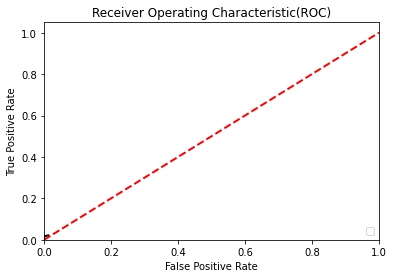

In [17]:
pos_prob = prediction_prob[:, 1]
thresholds = np.arange(0.0, 1.2, 0.1)
true_pos, false_pos = [0]*len(thresholds), [0]*len(thresholds)
for pred, y in zip(pos_prob, Y_test):
    for i, threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

true_pos_rate = [tp / 516.0 for tp in true_pos]
false_pos_rate = [fp / 1191.0 for fp in false_pos]

from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y_test, pos_prob))

import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(false_pos_rate, true_pos_rate, color='black',
         lw=lw)
plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic(ROC)')
plt.legend(loc="lower right")
plt.show()

# Menghitung akurasi dan confusion matrix untuk melihat seberapa akurat model yang sudah kita buat sebelumnya
# Pada model ini, saya mendapatkan akurasi ROC yang cukup baik yaitu berupa 0.96